# Read Gamma + Muons Simulation and Fit to Lab Data

### Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal

import ROOT
# import uproot as up

import sys
import math
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
from ROOT import gROOT, gBenchmark
from root_numpy import array2hist, hist2array, fill_hist
import matplotlib as mpl
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# import deDisperse_util as util
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_2443/4191743235.py:29: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


### Declare constants (calculated in JorgeAndrewUpdate-Copy1)

In [2]:
pe_mev = 53.31 # pe/MeV for a specfic prototype
rat = 11.354578745626334 # high gain/low gain counts (lab data)
spe = 109.0 # ADC/pe 

In [3]:
# Same but for Cs data
pe_mev_cs = 
rat_cs = 11.037464891979246
spe_cs = 101.0

In [4]:
# Same but for Bkg data
pe_mev_bkg = 54.59
rat_bkg = 10.984392763330062
spe_bkg = 114.0

### Import Simulated .ROOT Files

In [5]:
folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder
 
# Open ROOT files
f1460 = ROOT.TFile.Open(folder_g + "K40J_normalized.root","READ")
f2614 = ROOT.TFile.Open(folder_g + "Tl208J_normalized.root","READ")
muons = ROOT.TFile(folder_m + "muonsJ_normalized.root", "READ")

# Read the TTree for Gammas
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [6]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)
    
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)

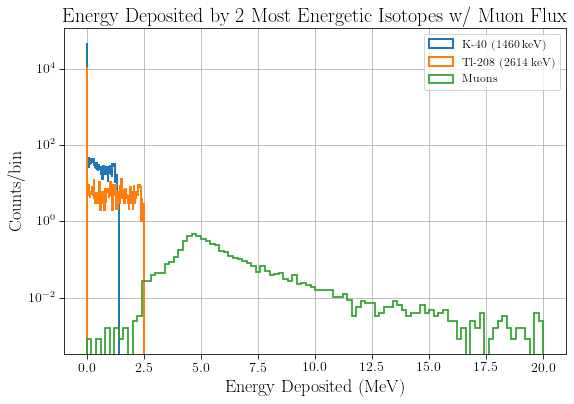

In [7]:
plt.figure(figsize=(9,6))

# Plot the gamma spectra
plt.hist(np.array(energyDeposited1460), bins=100, histtype="step", lw=2, label = "K-40 (1460 keV)");
plt.hist(np.array(energyDeposited2614), bins=100, histtype="step", lw=2, label = "Tl-208 (2614 keV)");

# Plot the muon spectrum
plt.hist(np.array(muonsEnergy), bins = 100, range = (0,20), histtype="step", lw = 1.7, label = "Muons", density = True);

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.title("Energy Deposited by 2 Most Energetic Isotopes w/ Muon Flux")
# plt.savefig("MuonsGammasFluxSim.jpg")
plt.show()

In [8]:
# Concatenate the energies into np arrays
g_energy = np.concatenate((energyDeposited1460,energyDeposited2614)) # gamma 
mu_energy = np.array(muonsEnergy) # muons
energy = np.concatenate((energyDeposited1460,energyDeposited2614, muonsEnergy)) # total

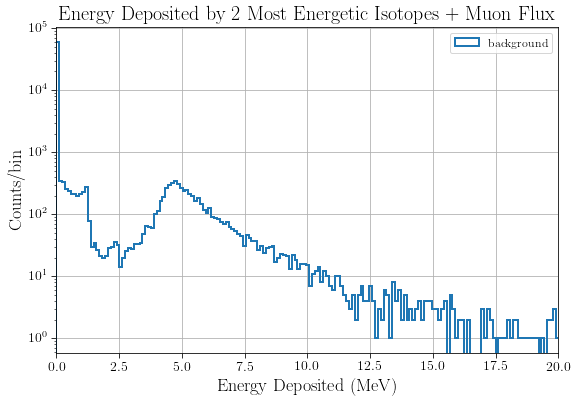

In [9]:
plt.figure(figsize=(9,6))

# Plot the gamma spectra
plt.hist(np.array(energy), bins=300, histtype="step", lw=2, label = "background");

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.xlim(0,20)
plt.title("Energy Deposited by 2 Most Energetic Isotopes + Muon Flux")
# plt.savefig("MuonsGammasFluxSimForCUORE.jpg")
plt.show()

### Import Lab Data using Parser that Tom Wrote (filename $\texttt{dt5202.py}$)

In [11]:
%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build

from dt5202 import dt5202_crunch
#from dt5202oldDAQ import dt5202_crunch as dt5202_crunchOld
ped = 50 #pedestal correction

%cd -

/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


In [12]:
#Import data files
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"
# sourceFolder_Cs = "/home/dt592/data/CsSwirlyDin1_20230710/" #Cesium data
# sourceFolder_bkg = "/home/dt592/data/BkgSwirlyDin1_10min_20230711/" #Background data

##########################

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
# print(onlyfiles)
data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=10000000, num_ch=1))

data = data_list[0]

for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

##########################

#f = sourceFolder+'Run0_list.dat'
#data = dt5202_crunch(f, num_ev=10000000, num_ch=2)

##########################
# # Importing Ceasium data

# onlyfiles_Cs = [f for f in os.listdir(sourceFolder_Cs) if '.dat' in f]
# data_list_Cs = []
# for file in onlyfiles_Cs:
#     data_list_Cs.append(dt5202_crunch(str(sourceFolder_Cs)+str(file), num_ev=10000000, num_ch=1))

# data_Cs = data_list_Cs[0]

# for j in range(1, len(data_list_Cs)):
#     data_Cs = np.append(data_Cs, data_list_Cs[j])
    
# ##########################
# # Importing Bkground to Filter out the Caesium Peak

# onlyfiles_bkg = [f for f in os.listdir(sourceFolder_bkg) if '.dat' in f]
# data_list_bkg = []
# for file in onlyfiles_bkg:
#     data_list_bkg.append(dt5202_crunch(str(sourceFolder_bkg)+str(file), num_ev=10000000, num_ch=1))

# data_bkg = data_list_bkg[0]

# for k in range(1, len(data_list_bkg)):
#     data_bkg = np.append(data_bkg, data_list_bkg[k])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


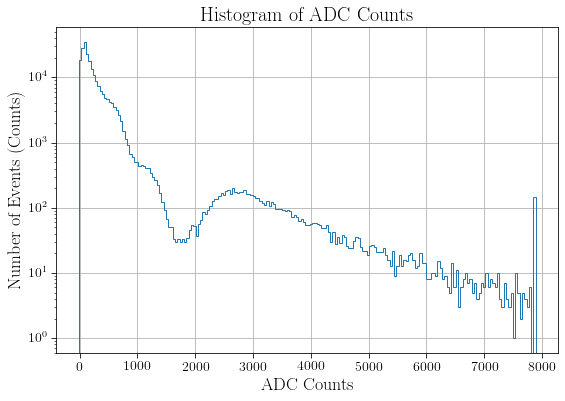

In [13]:
plt.figure(figsize=(9,6))
#plotting High Gain Data to View SPE peaks
#plt.hist(data['data']['high_gain'][:,0]-ped, bins=300, range=(500,2000),
 #        histtype='step');
plt.hist(data['data']['low_gain']-ped, bins=200,
         histtype='step');
# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts')
plt.yscale('log')
plt.grid()
# Can work on naming scheme
# plt.savefig(figure_folder + '/' + 'ADCHist.png')

### Convert both Simulated and Lab Data to PE, Plot Together, Apply Smearing

In [14]:
bg_pe = np.multiply(energy, pe_mev) # applies PE/MeV resolution to simulation

d = data['data']['low_gain']-ped
lab_pe = d.astype('float64')*rat/spe # turns ADC to PE

# cs_pe = (data_Cs['data']['low_gain']-ped) * rat_cs/spe_cs # Cesium data
# bkg_pe = (data_bkg['data']['low_gain']-ped) * rat_bkg/spe_bkg # Background

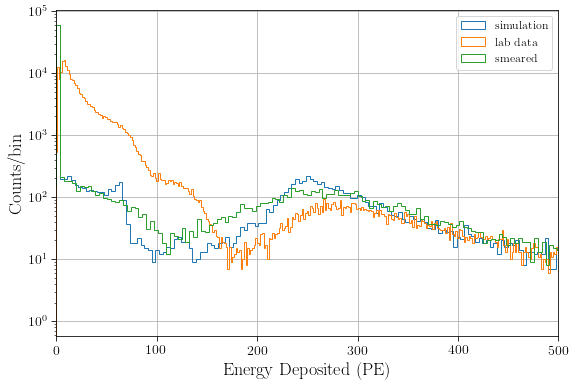

In [15]:
plt.figure(figsize=(9,6))

#apply smearing
bg_smeared = np.random.normal(loc=bg_pe, scale=3 * np.power(bg_pe,0.5))

# plot simulation
plt.hist(bg_pe, bins=500, histtype='step', label='simulation');
#plot lab data
plt.hist(lab_pe, bins=500, histtype='step', label='lab data');
#plot smearing
plt.hist(bg_smeared, bins=500, histtype='step', label='smeared');

plt.legend()
plt.grid()
plt.xlabel('Energy Deposited (PE)');
plt.xlim(0, 500)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.show()

### Make the Same Plot in MeV

In [42]:
sim_mev = bg_pe/pe_mev # Turn simulated energy data into MeV
# lab_mev = (d.astype('float64')*rat/spe)/pe_mev - 0.48347541705543495 # Turn low gain lab data into MeV
lab_mev = (d.astype('float64')*rat/spe)/pe_mev # Turn low gain lab data into MeV

<Figure size 864x576 with 0 Axes>

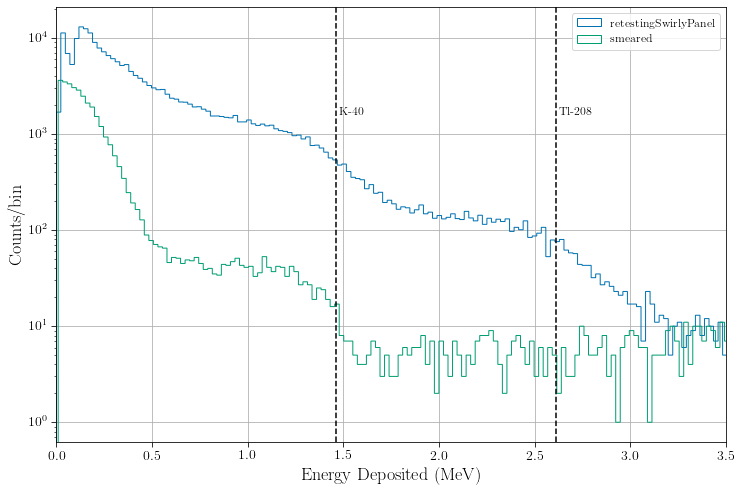

In [43]:
import matplotlib.style as style
mpl.style.use('seaborn-colorblind')

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))
sigma_smear = 0.158
#apply smearing
bg_smeared = np.random.normal(loc=bg_pe, scale= 53 * sigma_smear)
bg_smeared2 = np.random.normal(loc=bg_pe, scale= 1.7 * np.power(bg_pe, 0.5))


#define linspace for exponential decay
xp = np.linspace(5, 55, 500)

#plot simulation in MeV
# plt.hist(sim_mev, bins=9000, range=(0,pe_mev*4), histtype='step', label='simulation'); 
#plot lab data in MeV
plt.hist(lab_mev, bins=9000, range=(0,pe_mev*4),histtype='step', label='retestingSwirlyPanel'); 
#plot smearing in MeV
plt.hist(bg_smeared/pe_mev, bins=9000, range=(0.01, pe_mev*4), histtype='step', label='smeared');
# plt.hist(bg_smeared2/pe_mev, bins=9000, range=(0.01, pe_mev*4), histtype='step', label='smeared old');


#label isotope peaks
trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.75,'K-40',transform=trans)
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.75,'Tl-208',transform=trans)
# plt.text(0.67,0.75,'Cs-137',transform=trans)
# plt.axvline(0.662, color='k', linestyle='--')

# plt.plot(xp, exponential_decay(xp, *params), 'r-', label='exp. decay fit')

plt.legend()
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, 3.5)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
# plt.savefig("LabDataVsActualMuons.jpg")
plt.show()

### Calculate integral of landau-gauss fit to find muon flux

In [122]:
c1 = TCanvas( 'c1', 'Dynamic Filling Example 1', 200, 10, 700, 500 )
# c2 = TCanvas( 'c2', 'Dynamic Filling Example 2', 200, 10, 700, 500 )
# c3 = TCanvas( 'c3', 'Dynamic Filling Example 3', 200, 10, 700, 500 )


# Create ROOT histograms for each of the 3 plots
sim_hpx = ROOT.TH1D( 'Gaussian-convoluted Landau (sim)', 'Simulated background, 10 min run', 200, 0, 16)
lab_hpx = ROOT.TH1D( 'Gaussian-convoluted Landau (lab)', 'Lab data, 10 min run', 200, 0, 16)
sme_hpx = ROOT.TH1D( 'Gaussian-convoluted Landau (sme)', 'Smeared simulation, 10 min run', 200, 0, 16)

# Fill histograms in MeV by converting PE/MeV
fill_hist(sim_hpx, bg_pe/pe_mev)
fill_hist(lab_hpx, lab_pe/pe_mev)
fill_hist(sme_hpx, bg_smeared/pe_mev)

warnings.filterwarnings("ignore") #filter annoying root_numpy warnings

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TFile::Append>: Replacing existing TH1: Gaussian-convoluted Landau (sim) (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gaussian-convoluted Landau (lab) (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gaussian-convoluted Landau (sme) (Potential memory leak).


/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work
The muon flux is: 0.933/cm^2/min
Chi2/NDF: 1.4496901186958775
MPV: 4.6487601422841704
 FCN=89.3199 FROM MIGRAD    STATUS=CONVERGED     731 CALLS         732 TOTAL
                     EDM=7.48813e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   3.91408e-01   9.90326e-03   4.89483e-05   2.05308e-02
   2  LandauMPV    4.64876e+00   1.20747e-02   7.67669e-05  -5.65666e-03
   3  Normalisation   1.87707e+03   2.02044e+02   1.61484e-01   4.86496e-06
   4  GaussianSigma   2.58571e-01   2.77707e-02   2.23196e-05   4.64039e-02
                               ERR DEF= 0.5


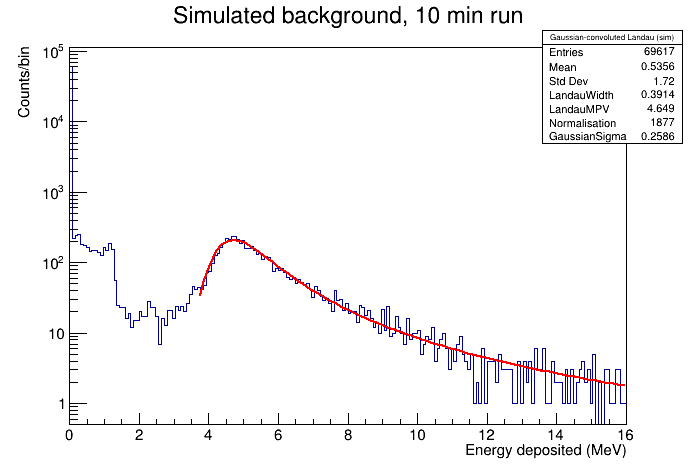

In [133]:
# Maybe it would be less confusing to include langaus in the same directory? I had trouble with this function because the file was not in the correct directory.
%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from langaus import LanGausFit
%cd - 

sim_hpx.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(sim_hpx, fitrange=(3.7,16))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
sim_hpx.GetXaxis().SetTitle("Energy deposited (MeV)");
sim_hpx.GetYaxis().SetTitle("Counts/bin");

sim_hpx.Draw()
func.Draw("same")
tf1 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 16, 4)
tf1.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf1.SetParameters(func.GetParameter(0), func.GetParameter(1), func.GetParameter(2), func.GetParameter(3))
tf1.Draw("same")

c1.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");

binWidth = sim_hpx.GetBinWidth(1)
muFlux = tf1.Integral(0,16)/(10*25*25*binWidth)

print("The muon flux is: %0.3f/cm^2/min"%muFlux)
print("Chi2/NDF:", func.GetChisquare()/func.GetNDF())
print("MPV:", func.GetParameter(1))

The muon flux is: 1.290/cm^2/min
Chi2/NDF: 3.499010748891472
MPV: 5.132235559339605
 FCN=450.522 FROM MIGRAD    STATUS=CONVERGED    1438 CALLS        1439 TOTAL
                     EDM=2.52362e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   6.47910e-01   1.54474e-02   1.62452e-04  -1.70851e-02
   2  LandauMPV    5.13224e+00   1.72176e-02   2.49197e-04   2.38672e-02
   3  Normalisation   1.67199e+03   1.92253e+02   2.74833e-01  -5.09462e-06
   4  GaussianSigma   4.14451e-01   4.76555e-02   6.90865e-05  -2.88865e-02
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


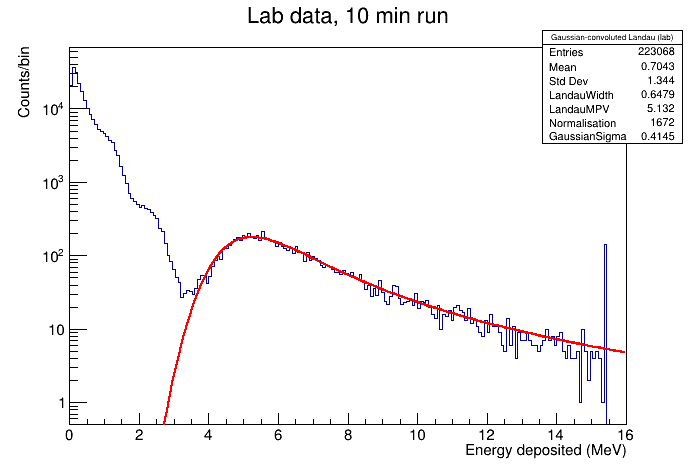

In [130]:
c2 = TCanvas( 'c2', 'Dynamic Filling Example 2', 200, 10, 700, 500 )

lab_hpx.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
funcL = fit.fit(lab_hpx, fitrange=(3.7,16))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
lab_hpx.GetXaxis().SetTitle("Energy deposited (MeV)");
lab_hpx.GetYaxis().SetTitle("Counts/bin");

lab_hpx.Draw()
funcL.Draw("same")
tf2 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 16, 4)
tf2.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf2.SetParameters(funcL.GetParameter(0), funcL.GetParameter(1), funcL.GetParameter(2), funcL.GetParameter(3))
tf2.Draw("same")

c2.Draw()

binWidth = lab_hpx.GetBinWidth(1)
muFlux = tf2.Integral(0,16)/(10*25*25*binWidth)

print("The muon flux is: %0.3f/cm^2/min"%muFlux)
print("Chi2/NDF:", funcL.GetChisquare()/funcL.GetNDF())
print("MPV:", funcL.GetParameter(1))

The muon flux is: 0.946/cm^2/min
Chi2/NDF: 1.5026345872579498
MPV: 4.592265862252392
 FCN=87.9374 FROM MIGRAD    STATUS=CONVERGED    1089 CALLS        1090 TOTAL
                     EDM=1.16527e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   4.08892e-01   1.37064e-02   6.19981e-05  -2.43051e-02
   2  LandauMPV    4.59227e+00   1.82470e-02   1.12969e-04  -5.20285e-03
   3  Normalisation   1.02013e+03   9.00396e+01   8.77852e-02   1.43660e-05
   4  GaussianSigma   4.83087e-01   4.42097e-02   4.34567e-05   2.72012e-02
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


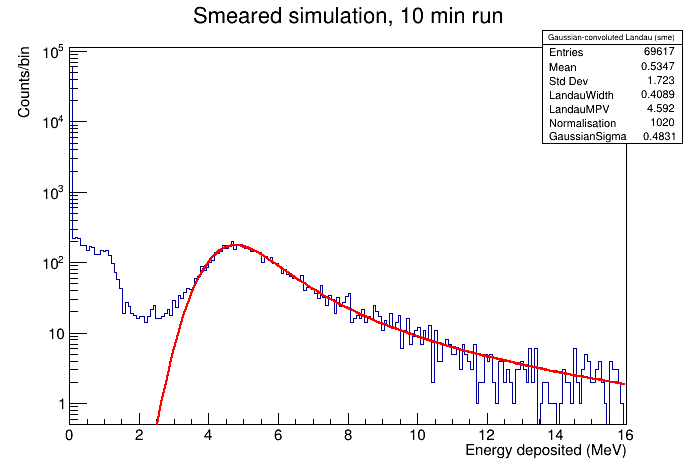

In [131]:
c3 = TCanvas( 'c3', 'Dynamic Filling Example 3', 200, 10, 700, 500 )

sme_hpx.Draw()
gPad.SetLogy();
gStyle.SetOptFit(2)
funcS = fit.fit(sme_hpx, fitrange=(3.7,16))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
sme_hpx.GetXaxis().SetTitle("Energy deposited (MeV)");
sme_hpx.GetYaxis().SetTitle("Counts/bin");

sme_hpx.Draw()
funcS.Draw("same")
tf3 = ROOT.TF1("landaugausfunction", ROOT.langaufun, 0, 16, 4)
tf3.SetParNames("LandauWidth","LandauMPV","Normalisation","GaussianSigma")
tf3.SetParameters(funcS.GetParameter(0), funcS.GetParameter(1), funcS.GetParameter(2), funcS.GetParameter(3))
tf3.Draw("same")

c3.Draw()

binWidth = sme_hpx.GetBinWidth(1)
muFlux = tf3.Integral(0,16)/(10*25*25*binWidth)

print("The muon flux is: %0.3f/cm^2/min"%muFlux)
print("Chi2/NDF:", funcS.GetChisquare()/funcS.GetNDF())
print("MPV:", funcS.GetParameter(1))

In [134]:
4.6487601422841704 - 5.132235559339605

-0.48347541705543495

### Fit Exponential Decay Curve to Lab Data

In [58]:
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [259]:
# Take gamma part of historgram data for fitting
hist, bins = np.histogram(lab_mev, range=(0.2,3), bins='auto')
bin_centers = (bins[:-1] + bins[1:]) / 2

# Delete all the 0 bins
nonzero_mask = hist != 0
bin_centers_filtered = bin_centers[nonzero_mask]
hist_filtered = hist[nonzero_mask]

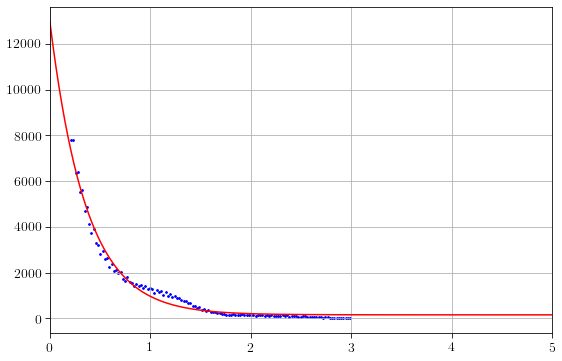

In [260]:
# Fit
p0 = [10, 1/10, 10**9]  # Initial guesses for a, b, c (used Wolfram-Alpha)
params, cov = curve_fit(exponential_decay, bin_centers_filtered, hist_filtered, p0=p0) 

# Plot fit to see
plt.figure(figsize=(9,6))

plt.scatter(bin_centers_filtered, hist_filtered, marker='o', color='b', s=3)
xp = np.linspace(0,30, 1000)

plt.plot(xp, exponential_decay(xp, *params), 'r-', label='Fit')

plt.grid()
plt.xlim(0, 5)
# plt.yscale('log')
plt.show()

<Figure size 648x432 with 0 Axes>

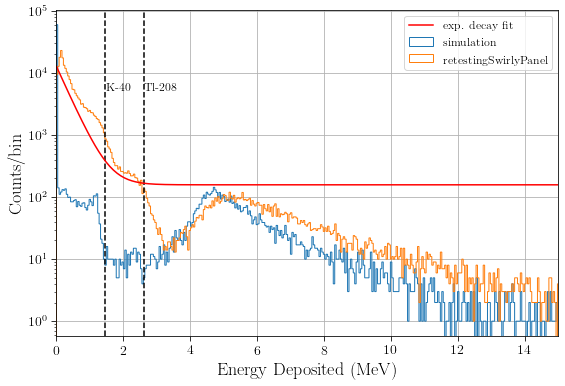

In [261]:
plt.figure(figsize=(9,6))
fig, ax = plt.subplots(figsize=(9,6))

#apply smearing
# bg_smeared = np.random.normal(loc=bg_pe, scale=35 * np.power(bg_pe,-0.5))

#define linspace for exponential decay
xp = np.linspace(0, 55, 1000)

#plot simulation in MeV
plt.hist(sim_mev, bins=5000, range=(0,pe_mev*4), histtype='step', label='simulation'); 
#plot lab data in MeV
plt.hist(lab_mev, bins=5000, range=(0,pe_mev*4),histtype='step', label='retestingSwirlyPanel'); 
#plot smearing in MeV
# plt.hist(bg_smeared/pe_mev, bins=500, range=(0.01, 50), histtype='step', label='smeared');

#label isotope peaks
trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,0.75,'K-40',transform=trans)
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,0.75,'Tl-208',transform=trans)
# plt.text(0.67,0.75,'Cs-137',transform=trans)
# plt.axvline(0.662, color='k', linestyle='--')

plt.plot(xp, exponential_decay(xp, *params), 'r-', label='exp. decay fit')

plt.legend()
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, 15)
# plt.ylim(0, 15)
plt.ylabel('Counts/bin');
plt.yscale("log")
# plt.savefig("LabDataVsActualMuons.jpg")
plt.show()

generate a random gaussian with scipy

In [ ]:
c1 = ROOT.